# Assignment 1 - Regression Models

*   Author: eeshanis
*   Date: 1/21/2026


## Part 1: Fuel Consumption as a Predictor of Horsepower
**Dataset:** `FuelEconomy.csv`  
**Task:** Predict Horsepower using Fuel Consumption and regression modeling

### Data loading and Inspection

In [99]:
# all the imports for the entire notebook
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt


In [100]:
# loading the fuel economy dataset into a pandas dataframe
df = pd.read_csv("/content/FuelEconomy.csv")

In [101]:
# getting basic information like shape and number of columns in the dataset
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())

#displaying the dataframe
display(df.head())

#getting statistics on the csv like count, mean, std etc...
print("\nSummary statistics:")
display(df.describe(include="all"))

#identifying the missing values in the columns
print("\nMissing values per column:")
display(df.isna().sum())

Shape: (100, 2)

Columns:
['Horse Power', 'Fuel Economy (MPG)']


,Horse Power,Fuel Economy (MPG)
0,118.770799,29.344195
1,176.326567,24.695934
2,219.262465,23.952010
3,187.310009,23.384546
4,218.594340,23.426739



Summary statistics:


,Horse Power,Fuel Economy (MPG)
count,100.000000,100.000000
mean,213.676190,23.178501
std,62.061726,4.701666
min,50.000000,10.000000
25%,174.996514,20.439516
50%,218.928402,23.143192
75%,251.706476,26.089933
max,350.000000,35.000000



Missing values per column:


,0
Horse Power,0
Fuel Economy (MPG),0


Summary of the initial data exploration:

*   This dataset has 2 columns each containing 100 data points. This means there are two possible features in this dataset, and 100 samples.
*   The two columns are continuous data and include: Horse Power and Fuel Economy (in miles per gallon)
*   There are no missing or null values in this dataset.
*   Horse Power is the target variable (dependent variable) to predict based on Fuel Economy (independent variable).



### **Utility Functions:**

For ease of use and clarity of code, I've included all the repetitive functions here:

1.   `split_data`: creates a 70/30 train-test-split with random state 42
2.   `compute_metrics`: computes the MSE, MAE, and R^2 metrics given the actual labels and the predicted labels.
3.   `prepare_xy`: This function drops the missing rows and splits the X from the y (target column)
4. `_get_linear_parts`: Extracting intercepts, coefficients, and feature names from either a linear or polynomial regression models.
5.  `print_fitted_equation`: prints the equation of the model that was fit
6.  `plot_actual_vs_predicted_test`: Presents a scatter plot on predicted versus actual values on the test set.
7.  `run_models_and_evaluate`: run, fit, and evaluate linear and/or polynomial regression models from the train and test sets.

These functions were sourced from the `Regression_Case_Study_Student_Performance.ipynb` from the in-class demo, and adapted to fit the goals of this assignment.


In [102]:
# This function splits the data into train test split sets with 70/30 split.
# It also sets the random state to 42 for reproducibility.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def split_data(X, y, test_size=0.30, random_state=42):
    return train_test_split(X, y, test_size=test_size, random_state=random_state)

In [103]:
# Returns the MSE, MAE, R^2
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def compute_metrics(y_true, y_pred):
    return {
        "MSE": mean_squared_error(y_true, y_pred),
        "MAE": mean_absolute_error(y_true, y_pred),
        "R^2": r2_score(y_true, y_pred),
    }

In [104]:
# This function drops the missing rows and splits the X from the y
# inputs are df_in, the raw data frame with both x and y, and target_col, the
#        y column to separate.
# outputs are the new, cleaned data frame, target column.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def prepare_xy(df_in, target_col):
    df_clean = df_in.dropna().copy()
    X = df_clean.drop(columns=[target_col])
    y = df_clean[target_col]
    return X, y

In [105]:
# Extract (intercept, coefficients, feature_names) from either:
# LinearRegression
# Pipeline(PolynomialFeatures -> LinearRegression)
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def _get_linear_parts(model, input_feature_names):
    # Plain LinearRegression
    if isinstance(model, LinearRegression):
        intercept = float(model.intercept_)
        coefs = np.array(model.coef_).ravel()
        feat_names = np.array(list(input_feature_names))
        return intercept, coefs, feat_names

    # Polynomial pipeline
    if hasattr(model, "named_steps") and "poly" in model.named_steps and "lr" in model.named_steps:
        poly = model.named_steps["poly"]
        lr = model.named_steps["lr"]

        feat_names = poly.get_feature_names_out(input_features=list(input_feature_names))
        intercept = float(lr.intercept_)
        coefs = np.array(lr.coef_).ravel()
        return intercept, coefs, np.array(feat_names)

    raise ValueError("Unsupported model type for equation printing.")

#Print a readable fitted equation.
#For polynomial models, the number of terms can become very large,
#so we print only the TOP-K terms by absolute coefficient magnitude.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def print_fitted_equation(model, input_feature_names, target_name, top_k_terms=15):
    intercept, coefs, feat_names = _get_linear_parts(model, input_feature_names)
    # Sort by absolute coefficient magnitude
    order = np.argsort(np.abs(coefs))[::-1]
    order = order[:min(top_k_terms, len(coefs))]

    terms = []
    for idx in order:
        terms.append(f"({coefs[idx]:+.4f}) * {feat_names[idx]}")

    eq = f"{target_name} = {intercept:.4f} " + " ".join(terms)

    print("\n--- Fitted Model Equation (Top Terms) ---")
    print(eq)
    if len(coefs) > top_k_terms:
        print(f"(Showing top {top_k_terms} terms out of {len(coefs)} total terms.)")

#Scatter plot of Actual vs Predicted values on the TEST set.
# We plot both series against a sample index, using:
# - Actual: blue circles
# - Predicted: red x's
# If test set is large, we randomly sample up to max_points points for readability.
# Source: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def plot_actual_vs_predicted_test(y_test, y_pred, title, max_points=300):
    y_test = np.array(y_test)
    y_pred = np.array(y_pred)

    n = len(y_test)
    if n > max_points:
        rng = np.random.default_rng(0)
        sel = rng.choice(n, size=max_points, replace=False)
        y_test = y_test[sel]
        y_pred = y_pred[sel]

    x = np.arange(len(y_test))

    plt.figure(figsize=(12, 4))
    plt.scatter(x, y_test, marker="o", alpha=0.8, label="Actual (Test)")
    plt.scatter(x, y_pred, marker="x", alpha=0.8, label="Predicted (Test)")
    plt.title(title)
    plt.xlabel("Test sample index (subset)")
    plt.ylabel(TARGET_COL)
    plt.grid(True, linestyle="--", alpha=0.4)
    plt.legend()
    plt.show()

#Train/evaluate linear (deg=1) + polynomial regression models.
# Returns a DataFrame of metrics.
# Also prints fitted equations and scatter plots (test set) for each model.
# Source / Modified from: Regression_Case_Study_Student_Performance.ipynb from the in-class demo
def run_models_and_evaluate(scenario_name, X, y, X_train, X_test, y_train, y_test,
                            degrees, target_col, show_equation, show_plots,
                            top_k_terms):
    rows = []

    for deg in degrees:
        if deg == 1:
            model = LinearRegression()
            model_name = "Linear Regression"
        else:
            model = Pipeline([
                ("poly", PolynomialFeatures(degree=deg, include_bias=False)),
                ("lr", LinearRegression())
            ])
            model_name = f"Polynomial Regression (degree={deg})"

        # Fit model
        model.fit(X_train, y_train)

        # Predict
        yhat_train = model.predict(X_train)
        yhat_test  = model.predict(X_test)

        # Metrics
        train_m = compute_metrics(y_train, yhat_train) #actual: y_train, predicted: yhat_train
        test_m  = compute_metrics(y_test, yhat_test)

        # Report equation + plot (TEST set)
        print("\n============================================================")
        print(f"Scenario: {scenario_name}")
        print(f"Model: {model_name}")
        print("============================================================")

        if show_equation:
            print_fitted_equation(
                model=model,
                input_feature_names=X_train.columns,
                target_name=target_col,
                top_k_terms=top_k_terms
            )

        if show_plots:
            plot_actual_vs_predicted_test(
                y_test=y_test,
                y_pred=yhat_test,
                title=f"{scenario_name} — {model_name} (Test Set: Actual vs Predicted)"
            )

        rows.append({
            "Scenario": scenario_name,
            "Model": model_name,
            "Train MSE": train_m["MSE"],
            "Train MAE": train_m["MAE"],
            "Train R^2": train_m["R^2"],
            "Test MSE": test_m["MSE"],
            "Test MAE": test_m["MAE"],
            "Test R^2": test_m["R^2"],
            "Train size": len(X_train),
            "Test size": len(X_test),
        })

    return pd.DataFrame(rows)

### **Train Test Split**

**Goal**: split the data such that 70% is used in training and 30% used for testing

In [106]:
#setting the target column to be horse power
TARGET_COL = "Horse Power"

#splitting up the data into x, or features used to train which is just Fuel Economy
#in this case, and the target column "Horse Power"
X, y = prepare_xy(df, target_col=TARGET_COL)

#70/30 train test split with random state 42 for reproducibility
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.30, random_state=42)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

X_train: (70, 1) X_test: (30, 1)
y_train: (70,) y_test: (30,)


### **Model Training**

With these X_train, X_test, y_train, and y_test datasets splits calculated in the previous step, this is the following procedure for training and evaluating the model.

1.   The model will be trained / fit on the X_train and Y_train data frames using `model.fit(X_train, y_train)`.
2.   The model will then predict 2 sets of target values for both X_train and X_test datasets.
* `model.predict(X_train)` will provide the yhat_train data since this is data the model has already seen before.
* `model.predict(X_test)` will provide the yhat_test data since this is data the model hasn't before.
3.   Using the predicted values of y for both train and test, the MSE, MAE, and R^2 error will be computed.
*  Training metrics are not great measures of model reliability since this is data the model has seen before, test metrics are more valuable in determining this.



Scenario: Fuel Economy for Horse Power
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
Horse Power = 500.3638 (-12.3785) * Fuel Economy (MPG)


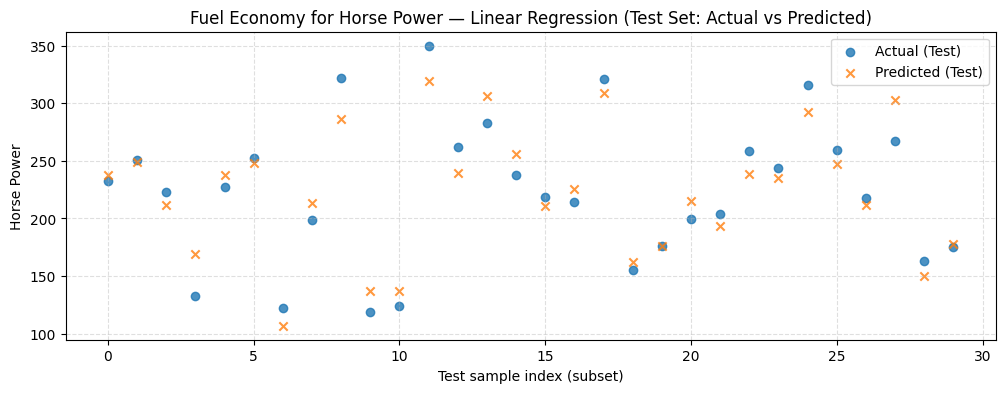


Scenario: Fuel Economy for Horse Power
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 457.3741 (-8.5915) * Fuel Economy (MPG) (-0.0800) * Fuel Economy (MPG)^2


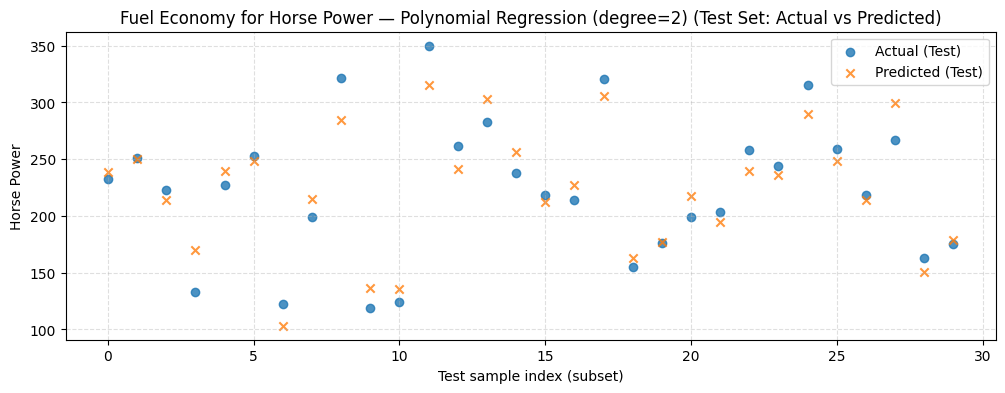


Scenario: Fuel Economy for Horse Power
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 355.6514 (+6.0952) * Fuel Economy (MPG) (-0.7505) * Fuel Economy (MPG)^2 (+0.0097) * Fuel Economy (MPG)^3


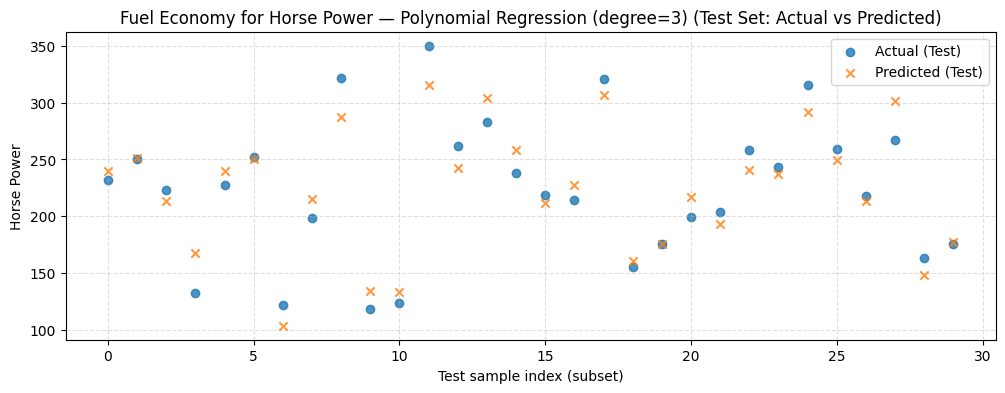


Scenario: Fuel Economy for Horse Power
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
Horse Power = 90.1049 (+61.1736) * Fuel Economy (MPG) (-4.7743) * Fuel Economy (MPG)^2 (+0.1339) * Fuel Economy (MPG)^3 (-0.0014) * Fuel Economy (MPG)^4


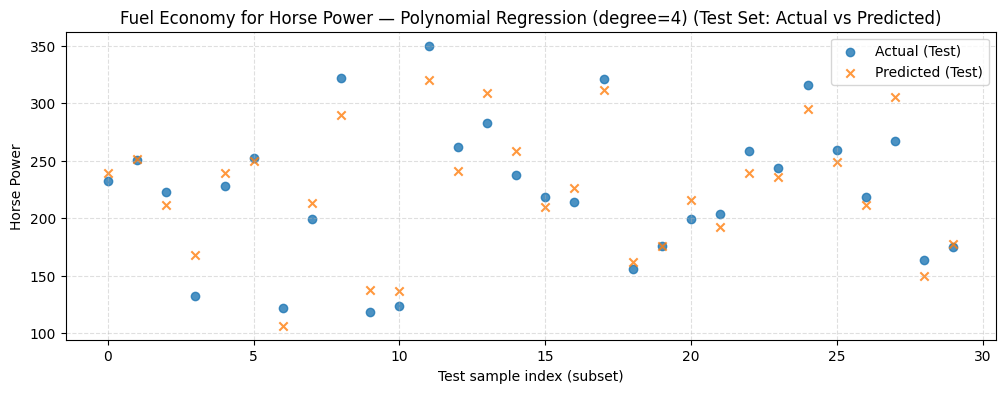

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Fuel Economy for Horse Power,Linear Regression,357.699180,16.061689,0.906320,318.561087,14.940628,0.912561,70,30
1,Fuel Economy for Horse Power,Polynomial Regression (degree=2),350.879731,15.995824,0.908106,331.105434,15.148330,0.909118,70,30
2,Fuel Economy for Horse Power,Polynomial Regression (degree=3),345.108668,15.746762,0.909618,318.404012,14.764973,0.912604,70,30
3,Fuel Economy for Horse Power,Polynomial Regression (degree=4),339.700171,15.508465,0.911034,313.798757,14.735471,0.913868,70,30


In [107]:
results_part1 = run_models_and_evaluate(
    scenario_name="Fuel Economy for Horse Power",
    X=X, y=y,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    degrees=(1, 2, 3, 4),
    target_col=TARGET_COL,
    show_equation=True,
    show_plots=True,
    top_k_terms=15
)

results_part1

Evaluation with training and testing metrics

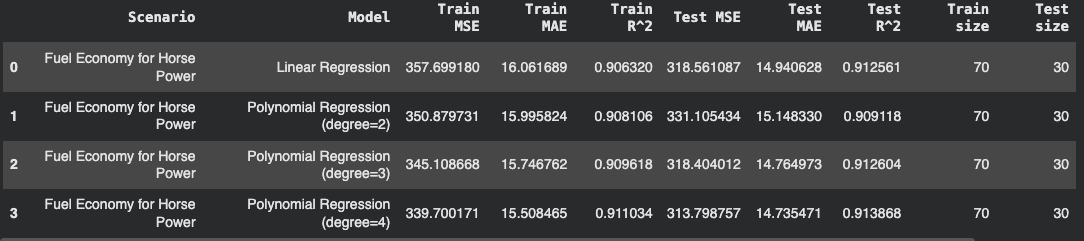

### **Discussion**



**1.   Which model performs best on the test set and why?**
    

*   The model that performs the best on the test set is Polynomial with degree 4. It has the lowest test MSE out of all the other models with 313.798, as well as the lowest test MAE of 14.735, and the highest test R^2 value 0.9138. These combined showcase a model that generalizes the best on unseen, test-time data.

**2.   Does increasing polynomial degree always improve performance? If not, explain what you observe.**
*   Increasing the polynomial degree doesn't always improve the performance. As polynomial degree increased, specifically at polynomial degree 2, there was a dip in performance, before it increased again. This was noted by the increase in test MSE from the linear regression model (318.56) to the polynomial degree 2 model (331.11), and subsequent decrease in the same test metric to 318.40 when evaluating the polynomial model with degree 3.
This is also mimicked by the test R^2 value with it worsening between the linear model and polynomial model with degree 3. With the test MSE increasing as polynomial degree increased from 1 to 2 and the test R^2 following a similar worsening model performance, it disproves the idea that increasing polynomial degree always improves the performance.

**3.   If a model performs unexpectedly poorly (e.g., low R2 or large test error), propose at least two plausible reasons**

*   The models here perform decently!



---



## Part 2: Daily Electricity Consumption based on Weather
**Dataset:** `electricity_consumption_based_weather_dataset.csv`  
**Task:** Predict daily electricity consumption using weather data and regression modeling

### Data loading and Inspection

In [108]:
# loading the fuel economy dataset into a pandas dataframe
df = pd.read_csv("/content/electricity_consumption_based_weather_dataset.csv")

In [109]:
# getting basic information like shape and number of columns in the dataset
print("Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print(" ")

#displaying the dataframe
print("First 5 rows of dataframe: ")
display(df.head())

#getting statistics on the csv like count, mean, std etc...
print("\nSummary statistics:")
display(df.describe(include="all"))

#identifying the missing values in the columns
print("\nMissing values per column:")
display(df.isna().sum())

Shape: (1433, 6)

Columns:
['date', 'AWND', 'PRCP', 'TMAX', 'TMIN', 'daily_consumption']
 
First 5 rows of dataframe: 


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
0,2006-12-16,2.5,0.0,10.6,5.0,1209.176
1,2006-12-17,2.6,0.0,13.3,5.6,3390.460
2,2006-12-18,2.4,0.0,15.0,6.7,2203.826
3,2006-12-19,2.4,0.0,7.2,2.2,1666.194
4,2006-12-20,2.4,0.0,7.2,1.1,2225.748



Summary statistics:


,date,AWND,PRCP,TMAX,TMIN,daily_consumption
count,1433,1418.000000,1433.000000,1433.000000,1433.000000,1433.000000
unique,1433,NaN,NaN,NaN,NaN,NaN
top,2010-11-26,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN
mean,NaN,2.642313,3.800488,17.187509,9.141242,1561.078061
std,NaN,1.140021,10.973436,10.136415,9.028417,606.819667
min,NaN,0.000000,0.000000,-8.900000,-14.400000,14.218000
25%,NaN,1.800000,0.000000,8.900000,2.200000,1165.700000
50%,NaN,2.400000,0.000000,17.800000,9.400000,1542.650000
75%,NaN,3.300000,1.300000,26.100000,17.200000,1893.608000



Missing values per column:


,0
date,0
AWND,15
PRCP,0
TMAX,0
TMIN,0
daily_consumption,0


These are what the columns represent:

*   date - Date of observation
*   AWND - Average daily wind speed (m/s)
*   PRCP - Daily precipitation (mm)
*   TMAX - Daily maximum temperature (°C)
*   TMIN - Daily minimum temperature (°C)
*   daily_consumption - Total daily electricity consumption (dependent value)

**Missing Values and Addressing them:**

There are 15 missing values in AWND (average daily wind speed). This could be due to many reasons like sensor failure or corrupt recording of the data, needing the data point to be dropped. I will replace the missing values with the wind speed of the day prior as the previous day's weather is a great indicator of the next day's weather. (I don't have a source for this but this is just what I've grown up hearing and I am handling it consistently).

The sorting of the dataframe based on the date to complete the forward fill should not impact the randomization of the data since the date column will be dropped before the train test split is done.

In [110]:
#replacing the missing AWND values with the AWND value of the previous day

#sorting the date in chronological order
df["date"] = pd.to_datetime(df["date"])
#cleaning up the indexes
df = df.sort_values("date").reset_index(drop=True)

#forward filling the missing values
df["AWND"] = df["AWND"].ffill()

#double checking there are no null values in AWND
print("\nMissing values per column:")
display(df.isna().sum())


Missing values per column:


,0
date,0
AWND,0
PRCP,0
TMAX,0
TMIN,0
daily_consumption,0


Date is not a valid format for the model training, therefore, I will drop it from the feature set.

In [111]:
df = df.drop(columns=["date"])


Summary of the initial data exploration + clean up:

*   This dataset has 6 original columns each containing 1433 total samples or data points (after making sure every column is filled).
*   The 6 columns are continuous data (except date) and include:

    *   date - Date of observation
    *   AWND - Average daily wind speed (m/s)
    *   PRCP - Daily precipitation (mm)
    *   TMAX - Daily maximum temperature (°C)
    *   TMIN - Daily minimum temperature (°C)
    *   daily_consumption - Total daily electricity consumption (dependent value)

*   Since date isn't a valid format for the model training, the column was dropped
  
*   There were missing/null values in this dataset in AWND, but they have been filled consistently with the previous day's AWND (refer above for the exact description of how they have been filled)
*   daily_consumption is the target variable (dependent variable) to predict based on AWND, PRCP, TMAX, and TMIN.



### **Train Test Split**

**Goal**: split the data such that 70% is used in training and 30% used for testing

In [112]:
#setting the target column to be daily_consumption
TARGET_COL = "daily_consumption"

#splitting up the data into x, or features used to train and the target column
X, y = prepare_xy(df, target_col=TARGET_COL)

#displaying the statistics of the new dataframe
#feature set includes: AWND, PRCP, TMAX, TMIN
display(X.describe(include="all"))

#70/30 train test split with random state 42 for reproducibility
X_train, X_test, y_train, y_test = split_data(X, y, test_size=0.30, random_state=42)

print("X_train:", X_train.shape, "X_test:", X_test.shape)
print("y_train:", y_train.shape, "y_test:", y_test.shape)

,AWND,PRCP,TMAX,TMIN
count,1433.000000,1433.000000,1433.000000,1433.000000
mean,2.634194,3.800488,17.187509,9.141242
std,1.139723,10.973436,10.136415,9.028417
min,0.000000,0.000000,-8.900000,-14.400000
25%,1.800000,0.000000,8.900000,2.200000
50%,2.400000,0.000000,17.800000,9.400000
75%,3.200000,1.300000,26.100000,17.200000
max,10.200000,192.300000,39.400000,27.200000


X_train: (1003, 4) X_test: (430, 4)
y_train: (1003,) y_test: (430,)


### **Model Training**

With these X_train, X_test, y_train, and y_test datasets splits calculated in the previous step, this is the following procedure for training and evaluating the model.

1.   The model will be trained / fit on the X_train and Y_train data frames using `model.fit(X_train, y_train)`.
2.   The model will then predict 2 sets of target values for both X_train and X_test datasets.
* `model.predict(X_train)` will provide the yhat_train data since this is data the model has already seen before.
* `model.predict(X_test)` will provide the yhat_test data since this is data the model hasn't before.
3.   Using the predicted values of y for both train and test, the MSE, MAE, and R^2 error will be computed.
*  Training metrics are not great measures of model reliability since this is data the model has seen before, test metrics are more valuable in determining this.



Scenario: Daily Electricity Consumption based on Weather
Model: Linear Regression

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2006.4887 (-20.4350) * TMIN (-14.0460) * TMAX (-3.4382) * AWND (-2.5904) * PRCP


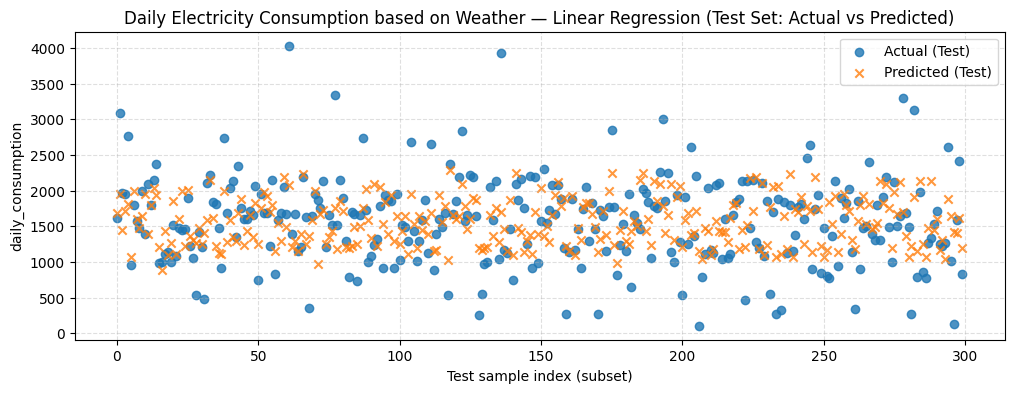


Scenario: Daily Electricity Consumption based on Weather
Model: Polynomial Regression (degree=2)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2231.5847 (-71.7930) * TMAX (+57.7178) * AWND (+31.6475) * TMIN (-18.0352) * AWND^2
(Showing top 4 terms out of 14 total terms.)


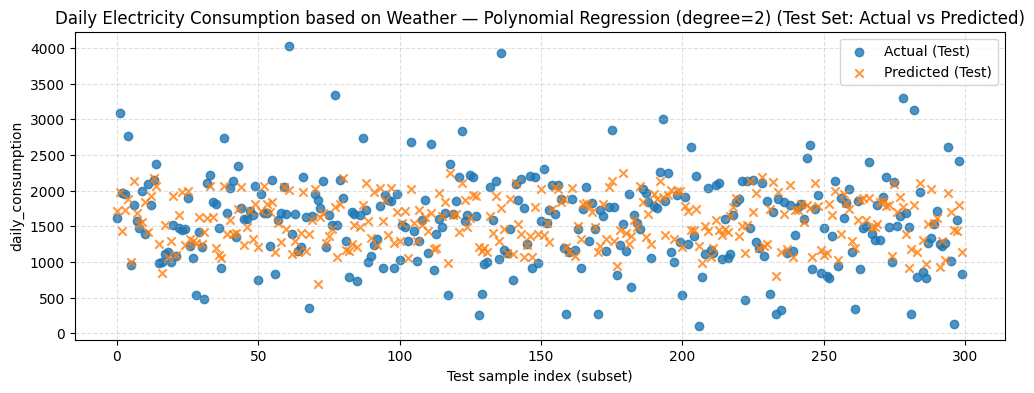


Scenario: Daily Electricity Consumption based on Weather
Model: Polynomial Regression (degree=3)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 1662.8849 (+491.1843) * AWND (-157.3933) * AWND^2 (+68.2111) * TMIN (-37.8605) * AWND TMIN
(Showing top 4 terms out of 34 total terms.)


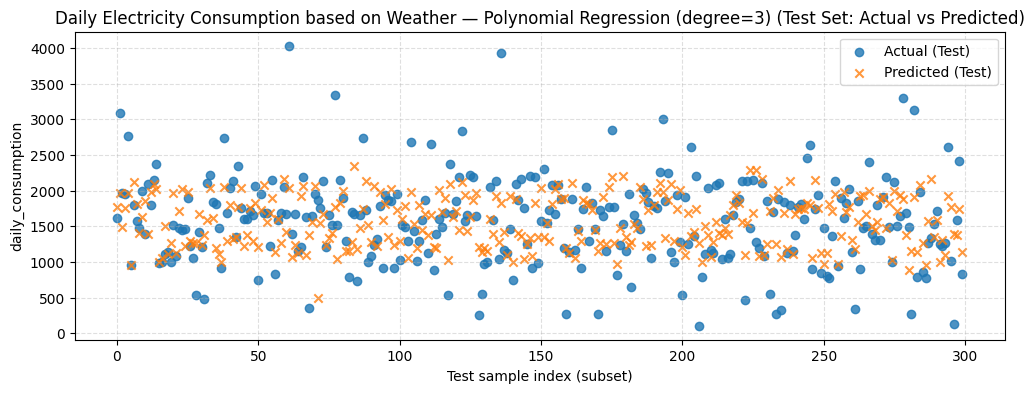


Scenario: Daily Electricity Consumption based on Weather
Model: Polynomial Regression (degree=4)

--- Fitted Model Equation (Top Terms) ---
daily_consumption = 2088.2337 (+165.4424) * AWND TMAX (-159.4523) * AWND TMIN (-119.0706) * TMAX (-100.9135) * AWND PRCP
(Showing top 4 terms out of 69 total terms.)


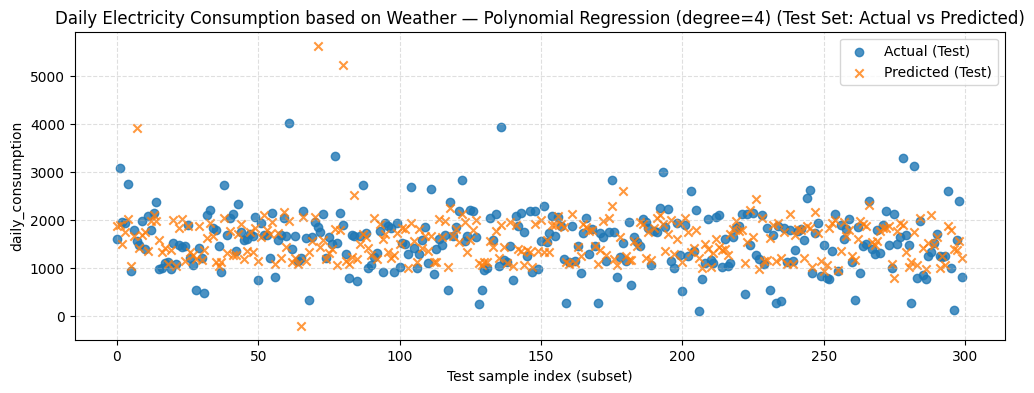

,Scenario,Model,Train MSE,Train MAE,Train R^2,Test MSE,Test MAE,Test R^2,Train size,Test size
0,Daily Electricity Consumption based on Weather,Linear Regression,274815.370567,386.913939,0.272974,237086.395015,365.440628,0.311875,1003,430
1,Daily Electricity Consumption based on Weather,Polynomial Regression (degree=2),268361.880021,382.154255,0.290047,234458.933480,362.496481,0.319501,1003,430
2,Daily Electricity Consumption based on Weather,Polynomial Regression (degree=3),261290.371379,377.677891,0.308754,238497.490667,368.674593,0.307779,1003,430
3,Daily Electricity Consumption based on Weather,Polynomial Regression (degree=4),254223.088075,374.967542,0.327451,387655.028222,410.934870,-0.125140,1003,430


In [113]:
results_part2 = run_models_and_evaluate(
    scenario_name="Daily Electricity Consumption based on Weather",
    X=X, y=y,
    X_train=X_train, X_test=X_test,
    y_train=y_train, y_test=y_test,
    degrees=(1, 2, 3, 4),
    target_col=TARGET_COL,
    show_equation=True,
    show_plots=True,
    top_k_terms=4
)

results_part2

Evaluation with training and testing metrics

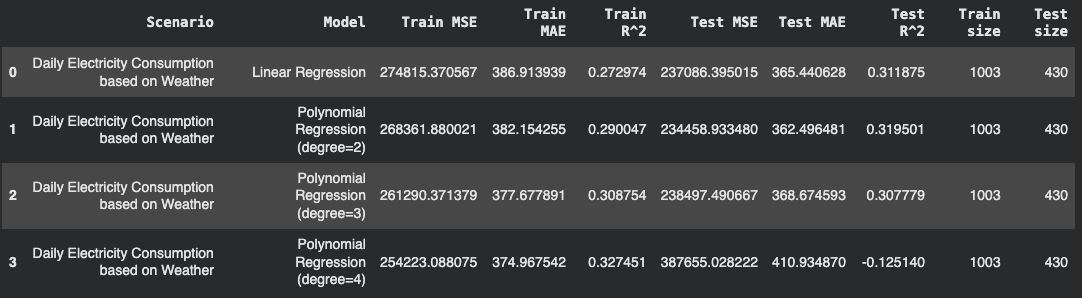

### **Discussion**



**1.   Which model generalizes best (best test performance), and what does that tell you about the
relationship between weather and electricity usage?**
    

*   The model that performs the best on the test set is Polynomial with degree 2. It has the lowest test MSE out of all the other models with 234458.93, as well as the lowest test MAE of 362.50, and the highest test R^2 value 0.3195. These combined showcase a model that generalizes the best on unseen, test-time data out of these four models, since the rest perform worse than this at test in all 3 metrics. This tells me that the relationship between weather and electricity usage is slightly non-linear which this low degree polynomial can capture better than just a linear regression model.

**2.   Do polynomial models improve the fit compared to linear regression? If yes, why might electricity
consumption have nonlinear dependence on weather?**
*   Polynomial models don't always improve the performance compared to a linear fit. As polynomial degree increased, specifically at polynomial degree 4, there was a significant dip in performance. This was noted by the sharp decrease in test MSE from 238497.50 to 387655.03 going from polynomial with degree 3 to 4. There was also a sharp decrease between polynomial with degree 3 to 4 for test R^2 going from 0.30778 to -0.125 further disproving this idea that polynomial models improve the fit compared to linear regression.
*   The nonlinearity is reasonable because electricity usage often respond slightly nonlinearly to the weather like only heating or cooling beyond a certain temperature threshold set by individuals. What the worsening performance with higher degree polynomials show is that they capture excessive complexity within the data that simply just doesn't exist.

**3.   If higher-degree models perform worse on the test set, explain this behavior using evidence from
metrics (e.g., train error decreases but test error increases).**

*   What I observed was that higher degree polynomials perform worse on the test set but better on the training set. This describes the models overfitting: when a model performs really well on the test set, but extremely poorly on the test set. The training MSE decreases as polynomial degree increases, falsely indicating that the performance is getting better. At test time, we see the opposite, testing MSE improves slightly between linear regression to the polynomial degree 2 model, however it starts to decline from there noted by the sharp decrease in test MSE from 238497.50 to 387655.03 going from polynomial with degree 3 to 4. This is similarly demonstrated through the other test metrics measured as well. There was a sharp decrease from test R^2 as well. The test R^2 improved between linear regression model and the polynomial with degree 2 model, but then declined dramatically going from 0.30778 to -0.125 from polynomial with degree 3 to degree 4. This shows that the models, as polynomial fit increased, started capturing too much variance of the data and could not generalize well on unseen test data.

**4.  If none of the models achieve good test performance, provide at least two reasons supported by
your outputs (e.g., limited feature set, high noise, unmodeled drivers such as occupancy/behavior,
seasonal effects).**

*   Although the polynomial regression model with degree 2 performs the best out of the models tested, the overall test performance is still fairly limited, with a maximum test R² of around 0.32. This means that a large portion of the variation in daily electricity consumption is still not being explained by the model.
*   One likely reason for this is the limited feature set. The model only uses weather related variables such as temperature, wind, and precipitation, but electricity usage is also heavily influenced by factors like humans behavior, living patterns, appliance usage, and building characteristics, none of which are included in the dataset.
*   Another reason the models don't perform that well is how noisy the data is. From the scatter plot, you can see that even when the weather is similar, electricity consumption can vary a lot from day to day. There are also clear outliers where usage spikes or drops unexpectedly, and the model has a hard time predicting those. This further suggests that factors beyond weather, like human behavior or unusual daily activity, play a big role. Because of this, the model tends to predict values near the average and struggles with extremes, which limits its test performance.
*   Because of these missing items, there is a significant amount of variation in electricity consumption that the model cannot learn well, and this limitation isn't something that can be fixed simply by increasing the polynomial degree.
